In [1]:
# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn import metrics

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline
from timeit import default_timer as timer
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller



# time series analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

- Store id 
- Day of Week 
- Date
- Customers: the number of customers on a given day.(Target Variable)
- Open: an indicator for whether the store was open: 0 = closed, 1 = open.
- Promo: indicates whether a store is running a promo on that day.
- StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. This has value as "0", "a", "b", "c"
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.


In [2]:
Store50 = pd.read_excel("Store_50.xlsx", parse_dates = True, index_col = 'Date')

In [3]:
Store50.head()

,Store,Day Of Week,Customers,Open,Promotion,State Holiday,School Holiday
Date,,,,,,,
2016-05-31,1044,1,884,1,1,0,0
2016-05-31,1041,1,1032,1,1,0,1
2016-05-31,1036,1,1070,1,1,0,0
2016-05-31,1047,1,2043,1,1,0,0
2016-05-31,1012,1,1239,1,1,0,0


In [4]:
print("The number of rows: ",Store50.shape[0], "\n""The number of columns: ",Store50.shape[1])

The number of rows:  43326 
The number of columns:  7


In [5]:
## Checking the number of stores for which we have the data

Store50['Store'].unique()

array([1044, 1041, 1036, 1047, 1012, 1037, 1027, 1005, 1011, 1004, 1043,
       1001, 1048, 1030, 1035, 1013, 1029, 1042, 1017, 1032, 1024, 1006,
       1007, 1002, 1019, 1000, 1009, 1023, 1016, 1050, 1031, 1010, 1034,
       1039, 1033, 1045, 1015, 1022, 1040, 1046, 1021, 1028, 1008, 1025,
       1014, 1020, 1038, 1003, 1018, 1026, 1049], dtype=int64)

In [6]:
## Selecting the store 1044 only for analysis.
## Here, we are also reversing the data as we need to contiguous data in the ascending order for a Time Series Analysis.

Store50_1044 = Store50[Store50.Store == 1044]. sort_index(ascending=True)

In [7]:
Store50_1044.head()

,Store,Day Of Week,Customers,Open,Promotion,State Holiday,School Holiday
Date,,,,,,,
2014-01-01,1044,2,0,0,0,a,1
2014-01-02,1044,5,473,1,0,0,0
2014-01-03,1044,5,483,1,0,0,0
2014-01-04,1044,1,0,0,0,b,1
2014-01-05,1044,3,0,0,1,a,0


In [8]:
Store50_1041 = Store50[Store50.Store == 1041]. sort_index(ascending=True)
Store50_1041.head()

,Store,Day Of Week,Customers,Open,Promotion,State Holiday,School Holiday
Date,,,,,,,
2014-01-01,1041,2,0,0,0,a,1
2014-01-02,1041,5,742,1,0,0,0
2014-01-03,1041,5,864,1,0,0,0
2014-01-04,1041,1,0,0,0,b,1
2014-01-05,1041,3,0,0,1,a,0


In [9]:
df = pd.DataFrame(columns=['Store_1044','Store_1041'])
df

,Store_1044,Store_1041


In [10]:
## Putting the two desired Time Series together in one dataframe

df['Store_1044'] = Store50_1044['Customers']
df['Store_1041'] = Store50_1041['Customers']
df

,Store_1044,Store_1041
Date,,
2014-01-01,0,0
2014-01-02,473,742
2014-01-03,483,864
2014-01-04,0,0
2014-01-05,0,0
...,...,...
2016-12-01,759,1003
2016-12-02,558,841
2016-12-03,556,875


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 882 entries, 2014-01-01 to 2016-12-05
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Store_1044  882 non-null    int64
 1   Store_1041  882 non-null    int64
dtypes: int64(2)
memory usage: 20.7 KB


The 'Customers' variable is our desired Time Series. So let us plot it to understand how the series looks like. This is a daily series.

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,8

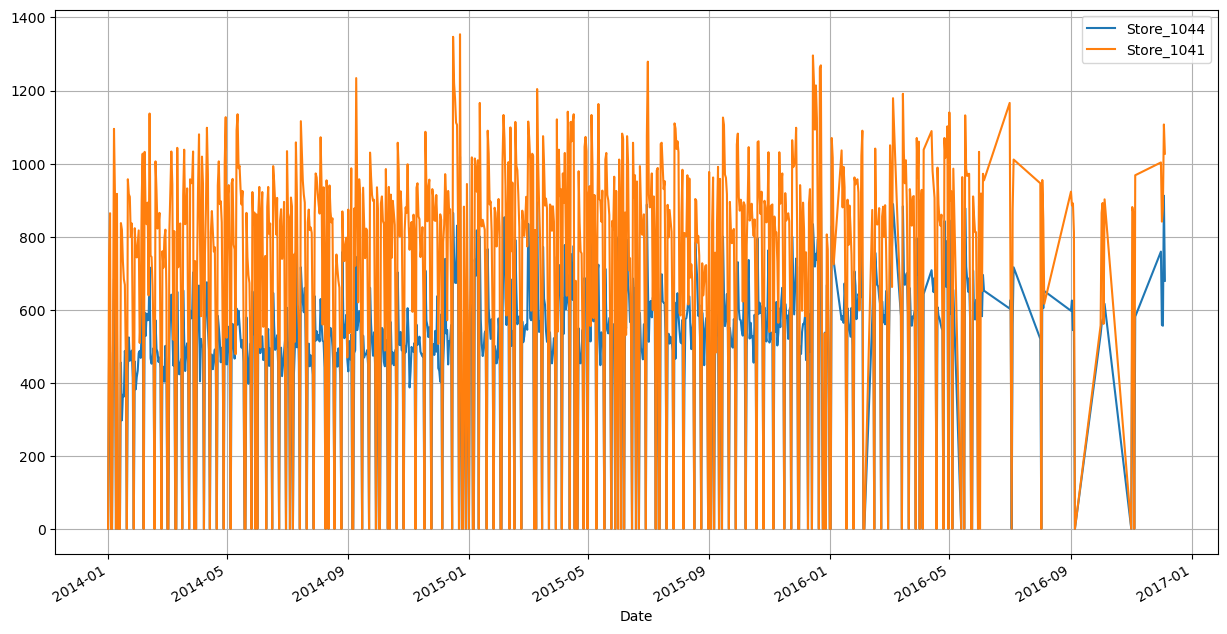

In [13]:
df.plot(grid=True);

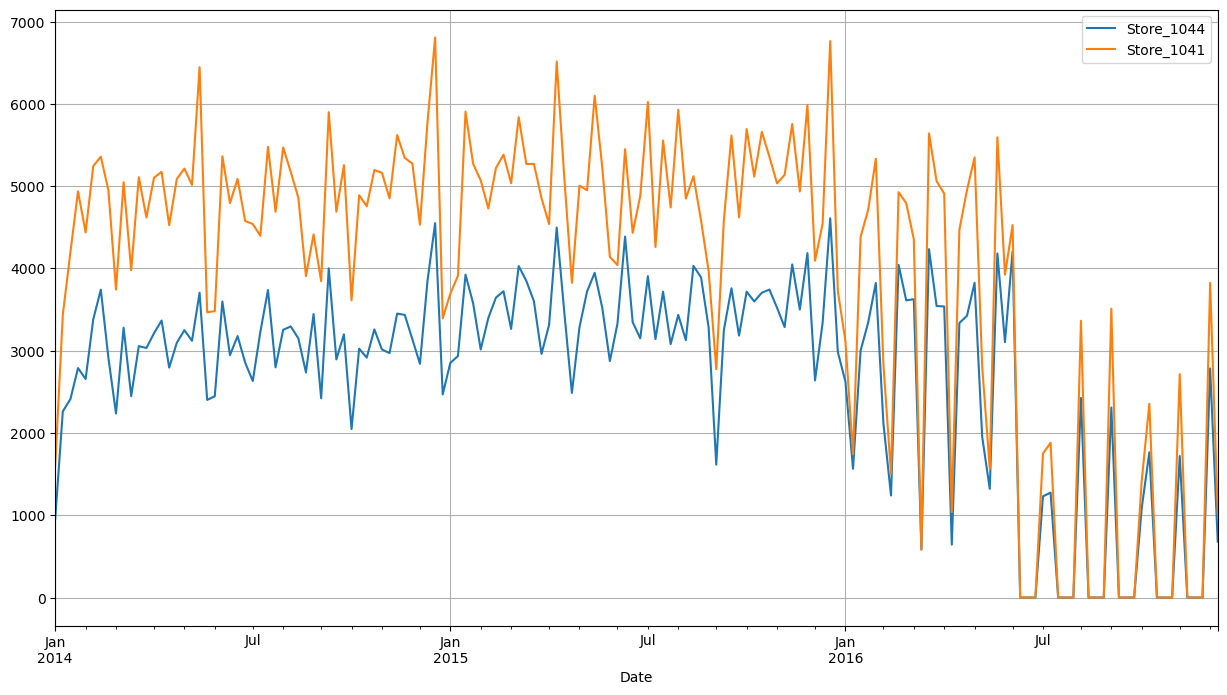

In [14]:
## Let us resample the data into a weekly time series to understand how the footfall of the customers change weekly.

df.resample('W').sum().plot(grid=True);

We see that the Store_1041 has a higher footfall of customers as compared to the Store_1044.

In [15]:
df.index.year.unique()

Index([2014, 2015, 2016], dtype='int32', name='Date')

Split the data into training and test. The test data starts from 2016 and onwards.

In [16]:
train=df[df.index.year !=2016]
test=df[df.index.year ==2016]

In [17]:
print('First 5 rows of the training data')
display(train.head())
print('Last 5 rows of the training data')
display(train.tail())
print('First 5 rows of the test data')
display(test.head())
print('Last 5 rows of the test data')
display(test.tail())

First 5 rows of the training data


,Store_1044,Store_1041
Date,,
2014-01-01,0,0
2014-01-02,473,742
2014-01-03,483,864
2014-01-04,0,0
2014-01-05,0,0


Last 5 rows of the training data


,Store_1044,Store_1041
Date,,
2015-12-27,537,535
2015-12-28,0,0
2015-12-29,667,806
2015-12-30,668,765
2015-12-31,462,473


First 5 rows of the test data


,Store_1044,Store_1041
Date,,
2016-01-01,0,0
2016-01-02,0,0
2016-01-03,828,1070
2016-01-04,833,1016
2016-01-05,732,724


Last 5 rows of the test data


,Store_1044,Store_1041
Date,,
2016-12-01,759,1003
2016-12-02,558,841
2016-12-03,556,875
2016-12-04,912,1107
2016-12-05,679,1027


Let us check the number of rows and columns of the training and test set.

In [18]:
print(train.shape)
print(test.shape)

(730, 2)
(152, 2)


Checking whether the training data is stationary.

In [19]:
## Importing the Augmented Dickey-Fuller test from the statsmodels library

from statsmodels.tsa.stattools import adfuller

In [20]:
## Defning a function
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,regression='ct')#running the adf test on the input time series
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    ## creating a series to format the output
    for key,value in dftest[4].items():##running a for loop to format the critical values of the test statistic
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [21]:
adf_test(train['Store_1044'])

Results of Dickey-Fuller Test:
Test Statistic                -6.690539e+00
p-value                        6.994789e-08
#Lags Used                     2.000000e+01
Number of Observations Used    7.090000e+02
Critical Value (1%)           -3.971596e+00
Critical Value (5%)           -3.416700e+00
Critical Value (10%)          -3.130705e+00
dtype: float64


In [22]:
adf_test(train['Store_1041'])

Results of Dickey-Fuller Test:
Test Statistic                  -6.147834
p-value                          0.000001
#Lags Used                      20.000000
Number of Observations Used    709.000000
Critical Value (1%)             -3.971596
Critical Value (5%)             -3.416700
Critical Value (10%)            -3.130705
dtype: float64


Series is stationary and hence no need for differentiation.

# Vector Auto-Regressive

Now, we are going to build a Vector Auto-Regressive Model. In this model, we will be using the lagged or past values of a particular Time Series to predict the other Time Series.

In this case, we have two stationary Time Series and we will be using these to build a VAR model.

Before we code up this model, let us understand how this model is interpreted and how the equation of this model looks like for two time-series.

The following is the example of a two-dimensional VAR(1) model.

# $y_{1,t}$ = $c_1$ + $\phi_{11,1}$$y_{1,t-1}$ + $\phi_{12,1}$$y_{2,t-1}$ + $e_{1,t}$
# $y_{2,t}$ = $c_2$ + $\phi_{21,1}$$y_{1,t-1}$ + $\phi_{22,1}$$y_{2,t-1}$ + $e_{2,t}$

Here e is the error term (white noise).

We can include the moving average terms to this kind of models as well. We can think of VAR models to AR models extended to multiple Time Series.

But we need to very careful in incorporating the number of variables in a VAR model and also be wary of the order of the VAR model. A complicated model by definition would work well on the training data but not so much on the test data. Introducing more time series would also include the error terms from those time series for the prediction of another time series.

VAR models are very powerful in a sense that it gives us an idea about the causation property a bit as well. If we get an improvement in the prediction accuracy by using a VAR model instead of an AR model, we can say that the past values of another time series aids in the prediction of our desired time series. 

# Build a VAR model.

In [23]:
import statsmodels.api as sm

In [24]:
## We need to convert these variables into float as that is the input that statsmodels api takes

train['Store_1044'] = train['Store_1044'].astype('float64')
train['Store_1041'] = train['Store_1041'].astype('float64')
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2014-01-01 to 2015-12-31
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Store_1044  730 non-null    float64
 1   Store_1041  730 non-null    float64
dtypes: float64(2)
memory usage: 17.1 KB


In [25]:
## We are running this iteration upto 7 days since this is a daily data and we have seen that the customer footfall
## of Store 1044 has a seasonality of 7.

for i in range(1,8):
    model = sm.tsa.VARMAX(train,order=(i,0),trend='c')
    model_result = model.fit()
    print('Order =',i)
    print('AIC:',model_result.aic)

Order = 1
AIC: 19230.82927050699
Order = 2
AIC: 19181.92083793189
Order = 3
AIC: 19184.994381837067
Order = 4
AIC: 19149.883690835555
Order = 5
AIC: 19143.76990335704
Order = 6
AIC: 19118.14666549384
Order = 7
AIC: 19051.728386783634


In [26]:
model = sm.tsa.VARMAX(train,order=(7,0),trend='c')
model_result = model.fit()
model_result.summary()

Dep. Variable:,"['Store_1044', 'Store_1041']",No. Observations:,730
Model:,VAR(7),Log Likelihood,-9492.864
,+ intercept,AIC,19051.728
Date:,"Sat, 21 Sep 2024",BIC,19203.299
Time:,15:20:29,HQIC,19110.205
Sample:,01-01-2014,,
,- 12-31-2015,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.00, 0.87",Jarque-Bera (JB):,"65.90, 1689.29"
Prob(Q):,"0.99, 0.35",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"1.33, 1.65",Skew:,"-0.70, -1.07"


In [27]:
pred = model_result.forecast(steps=len(test))
pred

,Store_1044,Store_1041
2016-01-01,396.208376,512.409707
2016-01-02,468.693410,648.265798
2016-01-03,539.146229,692.494745
2016-01-04,328.011515,482.042363
2016-01-05,520.922924,735.703200
...,...,...
2016-05-27,464.729810,697.960868
2016-05-28,464.729810,697.960868
2016-05-29,464.729810,697.960868
2016-05-30,464.729810,697.960868


In [28]:
## Calculating the RMSE for Store 1044

import math
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test['Store_1044'],pred['Store_1044'])
rmse = math. sqrt(mse)
print('Store_1044:',mse)
print('Store_1044:',rmse)

Store_1044: 73057.78180575721
Store_1044: 270.2920305997889


In [29]:
## Calculating the RMSE for Store 1041

mse = mean_squared_error(test['Store_1041'],pred['Store_1041'])
rmse = math. sqrt(mse)
print('Store_1041:',mse)
print('Store_1041:',rmse)



Store_1041: 139450.76235107196
Store_1041: 373.43106773683405


# Vector Auto-regression and Moving Average - (VARMA)

In [30]:
import os

In [31]:
from google.colab import drive 
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
%cd /content/drive/My\ Drive/


In [32]:
df1=pd.read_csv('varma_data.csv')

In [33]:
df2 = df1[(df1['Date'] > '2016-01-14') & (df1['Date'] <= '2017-01-30')]

In [34]:
df2.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1,2016-01-15,16354.330078,16354.330078,15842.110352,15988.080078,15988.080078,239210000
2,2016-01-19,16009.450195,16171.959961,15900.250000,16016.019531,16016.019531,144360000
3,2016-01-20,15989.450195,15989.450195,15450.559570,15766.740234,15766.740234,191870000
4,2016-01-21,15768.870117,16038.589844,15704.660156,15882.679688,15882.679688,145140000
5,2016-01-22,15921.099609,16136.790039,15921.099609,16093.509766,16093.509766,145850000


**A Standard define functions for an Time-Series model evaluation metrics**

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

**Checking for stationarity of data using ADF test function:**


In [ ]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [ ]:
df2.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

**Infere the variables are stationary:**

In [ ]:
for name, column in df2[['Open', 'High', 'Low', 'Close']].iteritems():
    Augmented_Dickey_Fuller_Test_func(df2[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Open
Test Statistic                  -0.776223
p-value                          0.826007
No Lags Used                     0.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.455656
Critical Value (5%)             -2.872678
Critical Value (10%)            -2.572705
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: High
Test Statistic                  -1.240162
p-value                          0.656085
No Lags Used                     2.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Low
Test Statistic                  -0.981046
p-value                          0.760114
No L

**We would be considering the train data that consists of all the data except the last 30 days, and the test data which consists of only the last 30 days to evaluate on future forcasting.**


In [ ]:
X = df2[['Open', 'High', 'Low', 'Close' ]]
train, test = X[0:-30], X[-30:]

**Perform the Pandas differencing on data to stationarize**

In [ ]:
train_diff = train.diff()
train_diff.dropna(inplace = True)

**Infere the variables are they stationarised after performing the first differencing.**


In [ ]:
for name, column in train_diff[['Open', 'High', 'Low', 'Close' ]].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Open
Test Statistic                -1.579687e+01
p-value                        1.085613e-28
No Lags Used                   0.000000e+00
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: High
Test Statistic                -1.172782e+01
p-value                        1.364178e-21
No Lags Used                   1.000000e+00
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Low
Test Statistic                  -3.997846
p-value                          0.001422


**Cointegration is used to check for the existence of a long-run relationship between two or more variables. However, the correlation does not necessarily mean “long run.”**

**We can see the test says that there is the presence of a long-run relationship between features.**


In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df2): 
    res = coint_johansen(df2,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df2.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9),
              ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


In [ ]:
cointegration_test(train_diff[['Open', 'High', 'Low', 'Close']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Open   >  311.57    > 40.1749   =>   True
High   >  201.62    > 24.2761   =>   True
Low    >  102.52    > 12.3212   =>   True
Close  >  32.21     > 4.1296    =>   True


In [ ]:
#pip install pmdarima


     |████████████████████████████████| 1.5MB 5.7MB/s 
     |████████████████████████████████| 2.1MB 21.7MB/s 
     |████████████████████████████████| 9.5MB 33.8MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from pmdarima import auto_arima

In [ ]:
pq = []
for name, column in train_diff[[ 'Open', 'High', 'Low', 'Close'  ]].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train_diff[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))


Searching order of p and q for : Open
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2891.139, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2887.158, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2889.136, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2889.135, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2885.680, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2887.514, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2887.501, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2889.092, Time=0.29 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.793 seconds
optimal order for:Open is: (0, 0, 0) 


Searching order of p and q for : High
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2806.440, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2811.486, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2808.164, Time=0.04

**Lets perform the inverse differencing function .**


In [ ]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res


In [ ]:
pq

[(0, 0, 0), (0, 0, 2), (0, 0, 2), (0, 0, 1)]

In [ ]:

df_results = pd.DataFrame(columns=['p', 'q','RMSE Open','RMSE High','RMSE Low','RMSE Close'])
print('Grid Search Started')
start = timer()
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(train_diff[[ 'Open', 'High', 'Low', 'Close'   ]], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 30)
        inv_res = inverse_diff(df2[[ 'Open', 'High', 'Low', 'Close'   ]] , result)
        Opensrmse = np.sqrt(metrics.mean_squared_error(test['Open'], inv_res.Open_1st_inv_diff))
        Highrmse = np.sqrt(metrics.mean_squared_error(test['High'], inv_res.High_1st_inv_diff))
        Lowrmse = np.sqrt(metrics.mean_squared_error(test['Low'], inv_res.Low_1st_inv_diff))
        Closermse = np.sqrt(metrics.mean_squared_error(test['Close'], inv_res.Close_1st_inv_diff))
        df_results = df_results.append({'p': i[0], 'q': i[2], 'RMSE Open':Opensrmse,'RMSE High':Highrmse,'RMSE Low':Lowrmse,'RMSE Close':Closermse }, ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')

Grid Search Started
 Running for (0, 0, 2)
 Running for (0, 0, 2)
 Running for (0, 0, 1)
 Total time taken to complete grid search in seconds: 25.104957567000383


In [ ]:
df_results.sort_values(by = ['RMSE Open','RMSE High','RMSE Low','RMSE Close'] )

,p,q,RMSE Open,RMSE High,RMSE Low,RMSE Close
0,0.0,2.0,263.292055,190.769946,286.703322,319.011671
1,0.0,2.0,263.292055,190.769946,286.703322,319.011671
2,0.0,1.0,314.116822,209.738485,336.623834,345.694531


**We can Infere that p=0, q=2 are the optimal which provides an the least RMSE.**

**Model building - fit and forecast, the time series data:**


In [ ]:
# from above example we can see that p=0 and q=2 gives least RMSE
model = VARMAX(train_diff[[ 'Open', 'High', 'Low', 'Close' ]], order=(0,2)).fit( disp=False)
result = model.forecast(steps = 30)


**let’s inverse the forecasted results, as shown here:**


In [ ]:
results = inverse_diff(df2[['Open', 'High', 'Low', 'Close' ]],result)

In [ ]:
results

,Open,High,Low,Close,Open_1st_inv_diff,High_1st_inv_diff,Low_1st_inv_diff,Close_1st_inv_diff
231,-97.539406,-125.338014,-18.161534,-4.520417,19931.079735,19903.281127,19852.229091,19966.610442
232,-13.712003,-35.694011,-2.271214,-7.055839,19917.367733,19867.587116,19849.957876,19959.554603
233,15.363224,15.536692,16.851177,16.495423,19932.730957,19883.123807,19866.809054,19976.050026
234,15.363224,15.536692,16.851177,16.495423,19948.094181,19898.660499,19883.660231,19992.545449
235,15.363224,15.536692,16.851177,16.495423,19963.457406,19914.197190,19900.511408,20009.040871
236,15.363224,15.536692,16.851177,16.495423,19978.820630,19929.733882,19917.362586,20025.536294
237,15.363224,15.536692,16.851177,16.495423,19994.183854,19945.270573,19934.213763,20042.031716
238,15.363224,15.536692,16.851177,16.495423,20009.547078,19960.807265,19951.064940,20058.527139
239,15.363224,15.536692,16.851177,16.495423,20024.910303,19976.343956,19967.916118,20075.022562
240,15.363224,15.536692,16.851177,16.495423,20040.273527,19991.880648,19984.767295,20091.517984


**Let's Evaluate the results individually,and infere from the output**


In [ ]:
for i in ['Open', 'High', 'Low', 'Close' ]:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)] , results[str(i)+'_1st_inv_diff'])

Evaluation metric for Open
Evaluation metric results:-
MSE is : 69322.70648306681
MAE is : 224.24223243977565
RMSE is : 263.2920554879444
MAPE is : 1.1277702479939442
R2 is : -10.34006693369997

Evaluation metric for High
Evaluation metric results:-
MSE is : 36393.17247139601
MAE is : 152.9002013818139
RMSE is : 190.7699464574963
MAPE is : 0.7673581832223293
R2 is : -5.539038158041874

Evaluation metric for Low
Evaluation metric results:-
MSE is : 82198.79470416254
MAE is : 238.7760429063243
RMSE is : 286.70332175292725
MAPE is : 1.2050807754416397
R2 is : -8.625550649982372

Evaluation metric for Close
Evaluation metric results:-
MSE is : 101768.44638431296
MAE is : 282.75981653930563
RMSE is : 319.011671235259
MAPE is : 1.4221000273357538
R2 is : -12.43348780600549



**Visualize the results and infere from plots:**

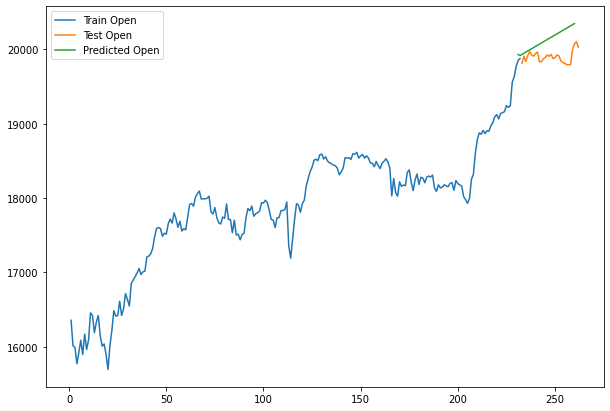

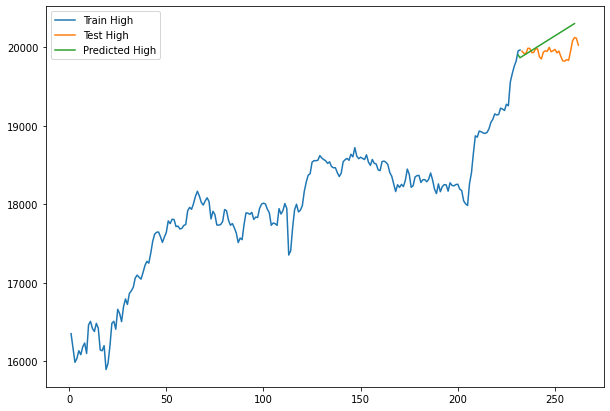

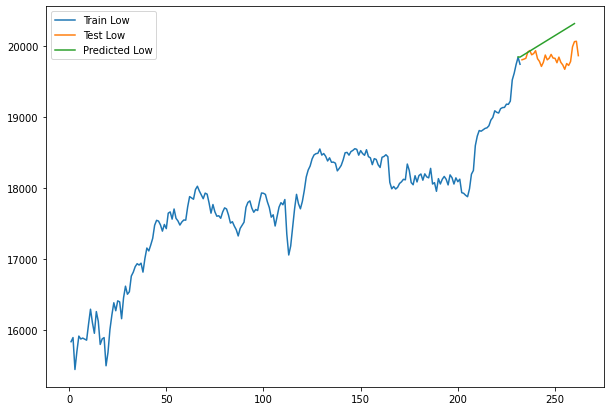

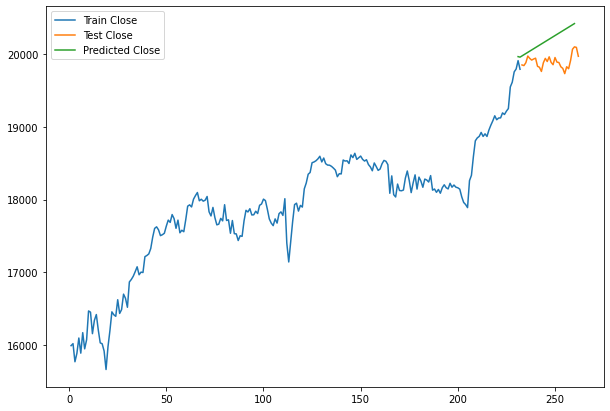

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['Open', 'High', 'Low', 'Close' ]:
    
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot( train[str(i)], label='Train '+str(i))
    plt.plot(test[str(i)], label='Test '+str(i))
    plt.plot(results[str(i)+'_1st_inv_diff'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

# END